#Function Definitions



In [1]:
# Copy/upload linear_models.py and data_util.py in Colab Files
import linear_models as lm
import data_util as data

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.preprocessing import normalize
from functools import partial

%matplotlib inline

def generate_random_coeffs(dim):
    rn = data.generate_random_numbers(1, dim, 1000, -10, 10)
    return rn

def true_f(x, coeffs):
    return coeffs.flatten()[0] + np.dot(coeffs.flatten()[1:], x.flatten())

def generate_df(N, dim,true_func, rn_func):
    cls1, cls2 = data.generate_two_classes(N/2, dim, true_func, rn_func)
    cols = ['x' + str(i) for i in range(1, dim+1)]
    df1 = pd.DataFrame(cls1, columns=cols)
    df1['y'] = 1
    df2 = pd.DataFrame(cls2, columns=cols)
    df2['y'] = -1
    df = pd.concat([df1, df2])
    df['x0'] = 1
    df = df[['x0'] + cols + ['y']]
    return df

def get_true_random_funcs(N, dim, num_grid_points, lb, ub, coeff_lb, coeff_ub):
    rns = data.generate_random_numbers(N, dim, num_grid_points, lb, ub)
    rn_func = partial(data.generate_random_numbers, num_grid_points = num_grid_points, lb = lb, ub = ub)
    coeffs = data.generate_random_numbers(1, dim+1, num_grid_points, coeff_lb, coeff_ub)
    norm_coeffs = coeffs.flatten()/coeffs.flatten()[-1]
    true_func = partial(true_f, coeffs = norm_coeffs)
    return true_func, rn_func, norm_coeffs

def gen_random_2class_data(N, dim,  num_grid_points, lb, ub, coeff_lb, coeff_ub):
    true_func, rn_func, norm_coeffs = get_true_random_funcs(N, dim, num_grid_points,
                                                            lb, ub, coeff_lb, coeff_ub)
    df = generate_df(N, dim, true_func, rn_func)
    return df, norm_coeffs

def plot_data(x1, df, norm_coeffs, norm_g, lb, ub):
        figsize = plt.figaspect(1)
        f, ax = plt.subplots(1, 1, figsize=figsize)
        cls1_df = df.loc[df['y']==1]
        cls2_df = df.loc[df['y']==-1]
        line = ax.plot(x1, -(norm_coeffs[0]+norm_coeffs[1]*x1), label='True Function')
        pluses = ax.scatter(cls1_df[['x1']].values, cls1_df[['x2']].values, marker='+', c= 'r', label='+1 labels')
        minuses = ax.scatter(cls2_df[['x1']].values, cls2_df[['x2']].values, marker=r'$-$', c= 'b', label='-1 labels')
        if norm_g:
            hypothesis = ax.plot(x1, -(norm_g[0]+norm_g[1]*x1), c = 'r', label='Final Hypothesis')

        ax.set_ylabel(r"$x_2$", fontsize=11)
        ax.set_xlabel(r"$x_1$", fontsize=11)
        ax.set_title('Data set size = %s'%N, fontsize=9)
        ax.axis('tight')
        legend_x = 2.0
        legend_y = 0.5
        ax.legend(['True Function', 'Final Hypothesis',
                   '+1 labels', '-1 labels', ],
                  loc='center right', bbox_to_anchor=(legend_x, legend_y))
        #ax.legend(handles=[pluses, minuses], fontsize=9)
        ax.set_ylim(bottom=lb, top=ub)
        plt.show()

def plot_data_hypothesis(df, xs, hypotheses, des_s):
    positives = df.loc[df['y']==1]
    negatives = df.loc[df['y']==-1]

    figsize = plt.figaspect(1)
    f, ax = plt.subplots(1, 1, figsize=figsize)

    ps = ax.scatter(positives[['x1']].values, positives[['x2']].values, marker='+', c= 'b', label='+1 labels')
    ns = ax.scatter(negatives[['x1']].values, negatives[['x2']].values, marker=r'$-$', c= 'r', label='-1 labels')

    labels = []
    for g, des in zip(hypotheses, des_s):
        label = 'Hypothesis: ' + des
        labels.append(label)
        norm_g = g/g[-1]
        hypothesis = ax.plot(xs, -(norm_g[0]+norm_g[1]*xs), label=label)

    ax.set_ylabel(r"$x_2$", fontsize=11)
    ax.set_xlabel(r"$x_1$", fontsize=11)
    ax.axis('tight')
    legend_x = 2.0
    legend_y = 0.5
    ax.legend(labels + ['+1 labels', '-1 labels'],
              loc='center right', bbox_to_anchor=(legend_x, legend_y))
    plt.show()

#Exercises and Problems

#### Exercise 3.1

Will PLA ever stop updating if the data is not linearly separable?

No. PLA will keep updating if the data is not linearly separable.

<img src='https://drive.google.com/uc?id=1cm-dDGIJmP-6C2FxfGSr0BDYmM2-_wrQ'>

Two data sets that are not linearly separable.
On the left, the data becomes linearly separable after the removal of just two examples, which could be considered noisy examples or outliers. The situation is encountered very often: even though a linear classifier seems appropriate, the data may not be linearly separable because of outliers or noise.

On the right, the data can be separated by a circle (nonlinear boundary) rather than a line.

In both cases, there will always be a misclassified training example if we insist on using a linear hypothesis, and PLA will never terminate.

#### Exercise 3.3
Consider the hat matrix $H = X(X^{T}X)^{-1}X^{T}$, where X is an N by d+1 matrix. and $X^{T}X$ is invertible.

(a) Show that $H$ is symmetric.

(b) Show that $H^{K} = H$ for any positive integer $K$.

(c) If $I$ is the identity matrix of size N, show that $(I-H)^{K} = I - H$ for any positive integer $K$.

(d) Show that $trace(H) = d + 1$, where the trace is the sum of diagonal elements. [Hint: $trace(AB) = trace(BA).$ Transpose properties - $(A + B)^{T}$ = $A^{T}$ + $B^{T}$; $(kA)^{T}$ = k$A^{T}$; $(AB)^{T}$ = $B^{T}$$A^{T}$]

1. (a) $H$ is symmetric.

\begin{align*}
H^T &= \left(X(X^TX)^{-1}X^T\right)^T\\
&= X(X^TX)^{-T}X^T\\
&= X(X^TX)^{-1}X^T\\
&= H\\
\end{align*}

1. (b) We show that $H^2=H$ first.

\begin{align*}
H^2 &= \left(X(X^TX)^{-1}X^T\right)\left(X(X^TX)^{-1}X^T\right)\\
&= X(X^TX)^{-1}(X^TX)(X^TX)^{-1}X^T\\
&= X(X^TX)^{-1}X^T\\
&= H\\
\end{align*}

Apply the above relationship repeatedly for $H^K$ we see that $H^K = H$.

1. (c) First show $(I-H)^2=I-H$.

\begin{align*}
(I-H)^2 &= (I-H)(I-H)\\
&= II - IH -HI + H^2\\
&= I - 2H + H^2\\
&= I-2H + H\\
&= I-H\\
\end{align*}

Apply above relationship repeatedly for $(I-H)^K$, we have $(I-H)^K = I-H$.

1. (d) Let $A=X(X^TX)^{-1}$, $B=X^T$, apply the property $\text{trace}(AB)=\text{trace}(BA)$, we have

\begin{align*}
\text{trace}(H) &= \text{trace}\left(X(X^TX)^{-1}X^T\right)\\
&= \text{trace}\left(AB\right)\\
&= \text{trace}\left(BA\right)\\
&=\text{trace}\left(X^TX(X^TX)^{-1}\right)\\
&=\text{trace}\left(I\right)\\
&= d+1\\
\end{align*}

where the identity matrix $I$ is of size $d+1$.

**Conclusion:**

The hat matrix $H$ is an analysis tool for in-sample and out-of-sample errors of linear regression.

The linear regression produces an estimate of $y$, $\hat{y}$ = $X$$w_{lin}$ which differs from $y$ due to in-sample error. $W_{lin}$ is a linear regression weight vector.

Substituting the expression for $w_{lin}$ we get $\hat{y}$ = $X(X^{T}X)^{-1}X^{T}y$. The estimate $\hat{y}$ is a linear transformation of the actual $y$ through matrix multiplication with $H$ = $X(X^{T}X)^{-1}X^{T}$.

Since  $\hat{y}$ = $Hy$, the matrix H 'puts a hat' on y, hence the name.

#### Exercise 3.4

<img src='https://drive.google.com/uc?id=1YymjfCyp-0qckz5Jnm80Y_ZnfEkSWxpd'>
<img src='https://drive.google.com/uc?id=1YjuZhPWbDmw1qexTOhRa3oWd7BKt-78P'>

1. (a) We have $y = Xw^{*}+\epsilon$, take this into the expression for in-sample estimate of $y$ is $\hat{y}$, we have

\begin{align*}
\hat{y} &= Hy\\
&= H(Xw^{*} + \epsilon)\\
&= Hxw^{*} + H\epsilon\\
&= X(X^TX)^{-1}X^TXw^{*} + H\epsilon\\
&= Xw^{*} + H\epsilon\\
\end{align*}

1. (b) The in-sample error vector is:

\begin{align*}
\hat{y} -  y &= Xw^{*} + H\epsilon - (Xw^{*} + \epsilon)\\
&= (H-I)\epsilon\\
\end{align*}

1. (c)

\begin{align*}
E_{in}(w_{lin}) &= \frac{1}{N}\|Xw_{lin}-y\|^2\\
&= \frac{1}{N}\|y-\hat{y}\|^2\\
&= \frac{1}{N}\|(I-H)\epsilon\|^2\\
&= \frac{1}{N}\epsilon^T(I-H)^T(I-H)\epsilon\\
&= \frac{1}{N}\epsilon^T(I-H^T)(I-H)\epsilon\\
&= \frac{1}{N}\epsilon^T(I-H)(I-H)\epsilon\\
&= \frac{1}{N}\epsilon^T(I-H)\epsilon\\
\end{align*}

1. (d)

\begin{align*}
E_{\mathcal{D}}\left[E_{in}(w_{lin})\right] &= E_{\mathcal{D}}\left[\frac{1}{N}\epsilon^T(I-H)\epsilon\right]\\
&= \frac{1}{N}\left(E_{\mathcal{D}}[\epsilon^T\epsilon]-E_{\mathcal{D}}[\epsilon^TH\epsilon]\right)\\
&= \frac{1}{N}\left(E_{\mathcal{D}}[\sum^N_{k=1}\epsilon_k^2]-E_{\mathcal{D}}[\sum^N_{i=1}\sum^N_{j=1}\epsilon_ih_{ij}\epsilon_j]\right)\\
&= \frac{1}{N}\left(\sum^N_{k=1}E_{\mathcal{D}}\epsilon_k^2-\sum^N_{i=1}\sum^N_{j=1}E_{\mathcal{D}}[\epsilon_ih_{ij}\epsilon_j]\right)\\
&= \frac{1}{N}\left(N\sigma^2-\sum^N_{i=1}E_{\mathcal{D}}[\epsilon_i^2h_{ii}]\right)\\
&= \frac{1}{N}\left(N\sigma^2-\sum^N_{i=1}h_{ii}E_{\mathcal{D}}[\epsilon_i^2]\right)\\
&= \frac{1}{N}\left(N\sigma^2-\sigma^2\text{trace}(H)\right)\\
&= \sigma^2\left(1-\frac{\text{trace}(H)}{N}\right)\\
&= \sigma^2\left(1-\frac{d+1}{N}\right)\\
\end{align*}

Here we used the independence of $\epsilon_i$, and also we assume $H$ is not random variable, so we are not doing expectation w.r.t. $x$, that's how we can pull $h_{ii}$ out of $E_{\mathcal{D}}[\epsilon_i^2h_{ii}]$.

1. (e) Since $X$ doesn't change, only $\epsilon$ changes, we have

\begin{align*}
\hat{y} -  y^\prime &= Xw^{*} + H\epsilon - (Xw^{*} + \epsilon^\prime)\\
&= H\epsilon - \epsilon^\prime\\
\end{align*}

Following the procedure in problem (c) and (d), we have

\begin{align*}
E_{\mathcal{D,\epsilon'}}\left[E_{test}(w_{lin})\right] &= E_{\mathcal{D},\epsilon'}\left[\frac{1}{N}\|y' - \hat{y}\|^2\right]\\
&= E_{\mathcal{D},\epsilon'}\left[\frac{1}{N}\|\epsilon' - H\epsilon\|^2\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon'}\left[(\epsilon' - H\epsilon)^T(\epsilon' - H\epsilon)\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon'}\left[(\epsilon^{\prime T} - \epsilon^TH^T)(\epsilon' - H\epsilon)\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon'}\left[(\epsilon^{\prime T} - \epsilon^TH)(\epsilon' - H\epsilon)\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon'}\left[\epsilon^{\prime T}\epsilon' - \epsilon^{\prime T}H\epsilon-\epsilon^TH\epsilon' + \epsilon^THH\epsilon\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon'}\left[\epsilon^{\prime T}\epsilon' - \epsilon^{\prime T}H\epsilon-\epsilon^TH\epsilon' + \epsilon^TH\epsilon\right]\\
&= \frac{1}{N}E_{\mathcal{D},\epsilon'}\left[\epsilon^{\prime T}\epsilon' + \epsilon^TH\epsilon\right]\\
&= \frac{1}{N}\left(\sum^N_{k=1}E_{\mathcal{D}}\epsilon_k^{\prime 2} + \sum^N_{i=1}\sum^N_{j=1}E_{\mathcal{D}}[\epsilon_ih_{ij}\epsilon_j]\right)\\
&= \sigma^2\left(1+\frac{d+1}{N}\right)\\
\end{align*}


Where we have used the fact that $\epsilon$ and $\epsilon^\prime$ are independent of each other and each $\epsilon_k$ and $\epsilon_k^\prime$ are independent among themselves.

**Conclusion:**
Figure below illustrates the learning curve of linear regression under the assumptions of the exercise, with the expected in-sample and out-of-sample errors calculated as from above. The best possible linear fit has expected error $σ^{2}$.

<img src='https://drive.google.com/uc?id=14CjphbYsXHxQalLHpuYDRfKR8rApALtp'>

#### Exercise 3.6

<img src='https://drive.google.com/uc?id=1OUFMzOFQArYk4phySFx17M4slsp2vAwF'>

1. (a) The probability to get $y_n$ is $P(y_n|x_n)$, by maximum likelihood method, we need maximize the likelihood, $\prod^N_{n=1} P(y_n|x_n)$, this is equivalent to maximize the logrithm of it: $\sum^N_{n=1}\ln(P(y_n|x_n))$, or minimize the negative of it: $-\sum^N_{n=1}\ln(P(y_n|x_n))$

When $y_n=+1$, $P(y_n|x_n)=h(x_n)$, and when $y_n=-1$, $P(y_n|x_n) = 1-h(x_n)$, separate the cases for $y_n=1$ and $y_n=-1$, we have:

\begin{align*}
E_{in}(w) &= -\sum^N_{n=1}\ln(P(y_n|x_n)) \\
&= -\sum^N_{n=1} I(y_n=+1)\ln h(x_n) + I(y_n=-1)\ln(1-h(x_n))\\
&= \sum^N_{n=1} I(y_n=+1)\ln\frac{1}{h(x_n)} + I(y_n=-1)\ln\frac{1}{(1-h(x_n))}\\
\end{align*}

1. (b) For $h(x) = \theta(w^Tx) = \frac{e^{w^Tx}}{1+e^{w^Tx}}$, we have $\ln \frac{1}{h(x_n)} = \ln (1+e^{-w^Tx_n})$ and $\ln \frac{1}{(1-h(x_n))} = \ln (1+e^{w^Tx_n})$. Combine them together we have

\begin{align*}
E_{in}(w) &= \sum^N_{n=1} I(y_n=+1)\ln (1+e^{-w^Tx_n}) + I(y_n=-1)\ln (1+e^{w^Tx_n})\\
&= \sum^N_{n=1}\ln (1+e^{-y_nw^Tx_n})\\
\end{align*}

Which is equivalent of minimizing the one in equation (3.9).


#### Exercise 3.7

<img src='https://drive.google.com/uc?id=1Brp6WD71Jq4OS-gFi9Z9GnAmBb6La28U'>

Take derivative of $E_{in}(w) = \frac{1}{N}\sum^N_{n=1}\ln (1+e^{-y_nw^Tx_n})$ with respect to $w$, we have:

\begin{align*}
\nabla E_{in}(w) &= -\frac{1}{N}\sum^N_{n=1} \frac{y_nx_n e^{-y_nw^Tx_n}}{1+e^{-y_nw^Tx_n}}\\
 &= -\frac{1}{N}\sum^N_{n=1} \frac{y_nx_n }{1+e^{y_nw^Tx_n}}\\
&= \frac{1}{N}\sum^N_{n=1} -y_nx_n \theta(-y_nw^Tx_n)\\
\end{align*}

When a sample is misclassified, $y_nw^Tx_n \lt 0$, so $\theta(-y_nw^Tx_n) \gt 0.5$, while when a sample is correctly classified, $\theta(-y_nw^Tx_n) \lt 0.5$, so the contribution of 'misclassified' example is more to the gradient than a correctly classified one.

#### Exercise 3.8

<img src='https://drive.google.com/uc?id=1lGxmhkbOMgpzatLwG7Jv8lmPHP0zwprk'>

$\hat{v}$ is the direction which gives largest decrease in $E_{in}$ only holds for small $\eta$, that's because when $\eta$ is large, we can't ignore the squared term and smaller terms in the Taylor expansion. The lower bound can't be achieved.

#### Exercise 3.9

<img src='https://drive.google.com/uc?id=1RKc5XqbOBrcbylRmPuhtWyOnfgM3pPF-'>

1. (a) See plot below
1. (b) When $y = 1$
  * If $s \ge 0$, $e_{class}(s,y) = 0$, $e_{sq}(s,y) = (1-s)^2 \ge 0$
  * If $s \lt 0$, $e_{class}(s,y) = 1$, $e_{sq}(s,y) = (1-s)^2 = 1 - 2s + s^2 \gt 1$
  
  In both cases, we have $e_{sq}(s,y) \ge e_{class}(s,y)$.
Similarly, we can prove that when $y=-1$, we have $e_{sq}(s,y) \ge e_{class}(s,y)$ as well.
So $e_{sq}(s,y) \ge e_{class}(s,y)$ for all cases of $s$ and $y$. The classification is upper bounded by the squared error.


1. (c) When $y=1$,
  * If $s \ge 0$, $e_{class}(s,y) = 0$, $e_{log}(s,y) = \ln(1+\exp(-ys)) = \ln(1+\exp(-s)) \ge \ln1 = 0$, also $\ln2 \gt 0$, so we have $\frac{1}{\ln2}e_{log}(s,y) \ge 0 = e_{class}(s,y)$.
  * If $s \lt 0$, $e_{class}(s,y) = 1$, $e_{log}(s,y) = \ln(1+\exp(-ys)) = \ln(1+\exp(-s)) \gt \ln2$, so $\frac{1}{\ln2}e_{log}(s,y) \gt 1 = e_{class}(s,y)$
  
  Similarly, we can prove that when $y=-1$, we have $\frac{1}{\ln2}e_{log}(s,y) \ge e_{class}(s,y)$ as well.
The logistic regression is an upper bound to the classification error.

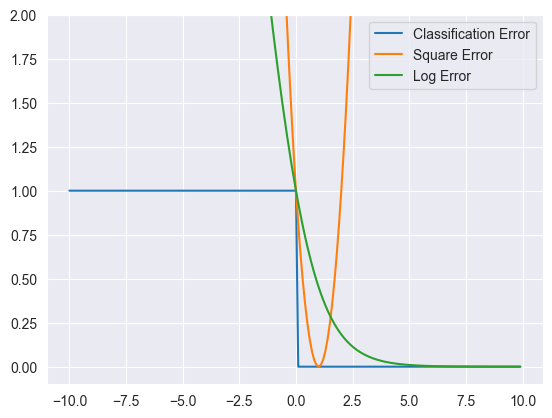

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def tanh(s):
    a = np.exp(s) - np.exp(-s)
    b = np.exp(s) + np.exp(-s)
    return a/b

def classification_error(s, y):
    signs = np.sign(s)
    return signs != y

def square_error(s, y):
    return (y-s)**2

def log_error(s, y):
    return np.log(1.0+np.exp(-y*s))

ss = np.arange(-10,10,0.1)
cls_err = classification_error(ss, 1)
sq_err = square_error(ss, 1)
log_err = log_error(ss, 1)/np.log(2)
plt.plot(ss, cls_err, label='Classification Error')
plt.plot(ss, sq_err, label='Square Error')
plt.plot(ss, log_err, label='Log Error')
plt.ylim(-0.1, 2)
plt.legend()
plt.show()

#### Exercise 3.10

<img src='https://drive.google.com/uc?id=1QnG6c8p2Kl-yf8iFGxxjv6_hTp0Dp9c9'>

1. (a) If $\eta = 1$, then the SGD algorithm will update the $w$ by: $w(t+1) = w(t) -\eta\nabla e_n(w)  = w(t) -\nabla e_n(w)$.

When $e_n(w) = \max(0, -y_n w^Tx_n)$, the derivative of $e_n(w)$ when $y_nw^Tx_n \gt 0$ (when the sample is correctly classified) is zero, the derivative is $-y_nx_n$ when $y_nw^Tx_n \lt 0$ (i.e. when the sample is misclassified).

Take the derivatives into the SGD update equation, we see that's exactly PLA.

1. (b) For logistic regression, we have $\nabla e_n(w) = \frac{-y_nx_n}{1+e^{y_nw^Tx_n}}$.
If $w$ is very large:
  * When $y_nw^Tx_n \gt 0$, $\nabla e_n(w) \approx 0$.
  * When $y_nw^Tx_n \le 0$, $\nabla e_n(w) \approx -y_nx_n$.
  
The above results are consistent with the values used in PLA.

This is another indication that the logistic regression weights can be used as a good approximation for classification.

#### Exercise 3.11

<img src='https://drive.google.com/uc?id=1514QMyTLZ_quCUYr6enwNgrM1WrrI6LS'>

Feature transformation $\Phi(x) = (1, x^2_1, x^2_2)$, a hyperplane in $\mathcal{Z}$ can be expressed as $\tilde{w}z = \tilde{w}_0 z_0 + \tilde{w}_1 z_1 + \tilde{w}_2 z_2 = \tilde{w}_0 + \tilde{w}_1 x^2_1 + \tilde{w}_2 x^2_2 = 0$.
1. (a) $|\tilde{w}_1| x^2_1 - |\tilde{w}_1| x^2_2 = c$ : Hyperbola

1. (b) $\tilde{w}_0 + \tilde{w}_1 x^2_1= 0$: It can be two vertical lines parallel to axis of $x1$.

1. (c) Ellipse.
1. (d) No solution. For any $x_1$ and $x_2$, $\tilde{w}z \gt 0$. So we can't find $\tilde{w}$ that satisfies the condition.

**Conclusion:**

The circular boundary in Figure 3.1 (Exercise 3.1) is given by $x_{1}^{2}$ + $x_{2}^{2}$ = 0.6.

Reframed as the nonlinear hypothesis $h(x)$ = sign(-0.6 + $x_{1}^{2}$ + $x_{2}^{2}$) separating the dataset perfectly.

We can view the nonlinear hypothesis $h(x)$ as a linear one after applying a nonlinear transformation on $x$ as illustrated below.

<img src='https://drive.google.com/uc?id=1Es6nZZDSh0VISUmn-JPHEAO2jzAU_tqM'>

We use  ̃ notation for quantites ($w$) and dimensionality ($d$) in $Z$.

The nonlinear hypothesis $h$ (circle) in the $X$ space can be represented by a linear hypothesis (line) in the $Z$ space.

$h(x)$ = $\tilde{g}(Φ(x))$

The set of hypotheses $h$ is denoted by $\tilde{H}_Φ$.

#### Exercise 3.13

<img src='https://drive.google.com/uc?id=1tMWYcTFsi98oDrmr3-qECh2d6-jgR7vk'>

$\Phi_2(x) = (1, x_1, x_2, x^2_1, x_1x_2, x^2_x)$, make the corresponding $\tilde{w}$ as $\tilde{w}_0, \dots, \tilde{w}_5$, we have

1. (a) $(x_1-3)^2 + x_2 -1 =-1 -6x_1 + x_2+ x^2_1$, we choose $\tilde{w}_0 = -1$, $\tilde{w}_1 = -6$, $\tilde{w}_2 = 1$, $\tilde{w}_3 = 1$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 0$.

1. (b) $(x_1-3)^2 + (x_2-4)^2 -1 = 24 - 6x_1 -8x_2 + x^2_1 + x^2_2$ , we choose $\tilde{w}_0 = 24$, $\tilde{w}_1 = -6$, $\tilde{w}_2 = -8$, $\tilde{w}_3 = 1$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 1$

1. (c) $2(x_1-3)^2 + (x_2-4)^2 -1 = 33 - 12x_1 -8x_2 + 2x^2_1 + x^2_2$, we choose $\tilde{w}_0 = 33$, $\tilde{w}_1 = -12$, $\tilde{w}_2 = -8$, $\tilde{w}_3 = 2$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 1$

1. (d) $(x_1-3)^2 - (x_2-4)^2 -1 = -8- 6x_1 + 8x_2 + x^2_1 - x^2_2$, we choose $\tilde{w}_0 = -8$, $\tilde{w}_1 = -6$, $\tilde{w}_2 = 8$, $\tilde{w}_3 = 1$, $\tilde{w}_4 = 0$,  $\tilde{w}_5 = -1$

1. (e) $2(x_1+x_2-3)^2 + (x_1-x_2-4)^2 -1 = 33- 20x_1 - 4x_2 + 3x^2_1+ 2x_1x_2 +3x^2_2$, we choose $\tilde{w}_0 = 33$, $\tilde{w}_1 = -20$, $\tilde{w}_2 = -4$, $\tilde{w}_3 = 1$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 3$

1. (f) $2x_1 + x_2 -1$, we choose $\tilde{w}_0 = -1$, $\tilde{w}_1 = 2$, $\tilde{w}_2 = 1$, $\tilde{w}_3 = 0$, $\tilde{w}_4 = 0$, $\tilde{w}_5 = 0$.

#### Exercise 3.14

<img src='https://drive.google.com/uc?id=1-wusoUZtgtFtBY9pDcSsl4g9YQJUL3nE'>

Consider the $Q$th order polynomial transform $\Phi_{Q}$ for $\mathcal{X} = \mathcal{R}^d$. Let's count the terms with exactly $q$-degree that can be created with $x_1,x_2, \dots, x_d$.
There are total of $q+d-1 \choose d-1$ such terms. See [Number of polynomial terms for certain degree and certain number of variables](https://mathoverflow.net/questions/225953/number-of-polynomial-terms-for-certain-degree-and-certain-number-of-variables/225963#225963).

So the total terms for the $Q$th order polynomical transform (which is also the dimensionality $\tilde{d}$ of the feature space $\mathcal{Z}$) is (Excluding the constant $1$):

\begin{align*}
\tilde{d}(d, Q) &= \sum^Q_{q=1}{ q+d-1 \choose d-1}\\
&= {d \choose d-1} + {d+1 \choose d-1} + \dots + {Q+d-1 \choose d-1}\\
&= {d \choose 1} + {d+1 \choose 2} + \dots + {Q+d-1 \choose Q}\\
&= ({d+1 \choose 1} -{d \choose 0}) + ({d+2 \choose 2} -{d+1 \choose 1}) + \dots + ({d+Q \choose Q} - {d+Q-1 \choose Q-1})\\
&= {d+Q \choose Q} - 1\\
\end{align*}

Where we have applied the equality: ${N \choose k} = {N-1 \choose k} + {N-1 \choose k-1}$

In [3]:
from scipy.special import comb  #calculates "N choose k"
print('Feature Space Dimensionality')
ds = [2,3,5,10]
Qs = [2,3,5,10]
for d in ds:
    for Q in Qs:
        r = comb(d+Q, Q) - 1
        print('d = ', d, ' Q = ', Q, ': ', int(r))

Feature Space Dimensionality
d =  2  Q =  2 :  5
d =  2  Q =  3 :  9
d =  2  Q =  5 :  20
d =  2  Q =  10 :  65
d =  3  Q =  2 :  9
d =  3  Q =  3 :  19
d =  3  Q =  5 :  55
d =  3  Q =  10 :  285
d =  5  Q =  2 :  20
d =  5  Q =  3 :  55
d =  5  Q =  5 :  251
d =  5  Q =  10 :  3002
d =  10  Q =  2 :  65
d =  10  Q =  3 :  285
d =  10  Q =  5 :  3002
d =  10  Q =  10 :  184755


#### Exercise 3.16

<img src='https://drive.google.com/uc?id=1scE0Ol8UztHFlW5kv1S_Jw-z-lVvP-mV'>

Steps of the algorithm that combines $\Phi_3$ with linear regression.

1. For each $x \in X$, apply $\Phi_3$ to obtain the matrix $Z$
1. Compute the pseudo-inverse $X^\dagger$ of the matrix $Z$
1. Return $w_{lin} = X^\dagger y$

If the dimension of data is large and the order of polynomial transformation is big, the resulting dimension in the feature space will grow in polynomial. The matrix $Z$ will be of size $N \times \tilde{d}$. The main computational cost will be spent on the calculation of the pseudo-inverse $X^\dagger$.

**Conclusion:**
When choosing the appropriate dimension for feature transform we have the approximation-generalization tradeoff for linear models.
1. Higher $\tilde{d}$, better chance of being linearly separable (lower $E_{in}$ as a good fit to the data) and lower generalization to new data.
1. Lower $\tilde{d}$, possibly not linearly separable (higher $E_{in}$) and better generalization to new data.

#### Problem 3.1

<img src='https://drive.google.com/uc?id=1CJUCTzzXsuJUdW0bKxynBwpq5yUu0sAt'>


From the graphs below we can see that PLA and linear regression achieves very close solution.
Consider a hyperplane $y = w_0 + w_1x_1 + w_2x_2$ for the $-1$ and $1$ points given $x$ in the space.
Once we find the $w$ through linear regression, we let $w_0 + w_1x_1 + w_2x_2=0$, this hyperplane should approximately separate the points.


Number of positive points:  1014
Number of negatives points:  986
Final correctness:  2000 . Total iteration:  22
Final w: [16.          0.31352149 48.7478991 ]
Liner regression coefficients:  [ 0.24907875 -0.00777384  0.08035234]


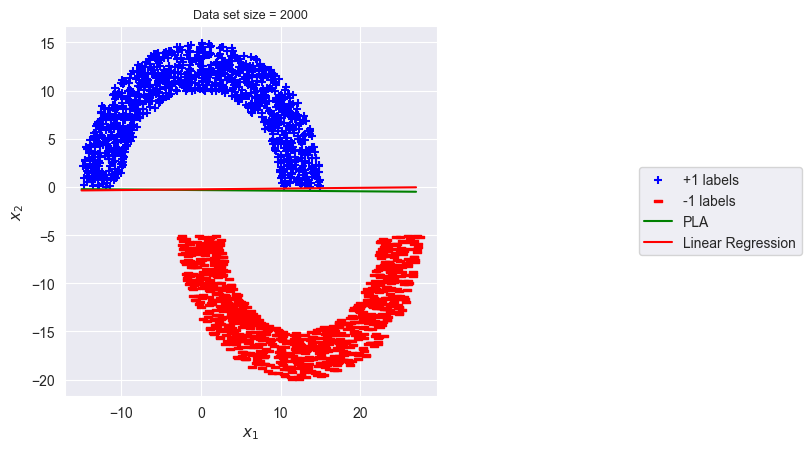

In [4]:
#### Problem 3.1 (a and b)
N = 2000
max_v = 10000
rad, thk = 10, 5
sep = 5
eta = 1
use_adaline=False
maxit = 1000
dim = 2

radii, radians = data.generate_random_ring(N, rad, rad + thk, max_v)
xs, ys, signs = data.move_bottom_ring_and_assign(radii, radians, rad + thk / 2.0, -sep)
df = pd.DataFrame({'x1':xs.flatten(), 'x2':ys.flatten(), 'y':signs.flatten()})
df['x0'] = 1
df = df[['x0','x1','x2','y']]
positives = df.loc[df['y']==1]
negatives = df.loc[df['y']==-1]

figsize = plt.figaspect(1)
f, ax = plt.subplots(1, 1, figsize=figsize)

ps = ax.scatter(positives[['x1']].values, positives[['x2']].values, marker='+', c= 'b', label='+1 labels')
ns = ax.scatter(negatives[['x1']].values, negatives[['x2']].values, marker=r'$-$', c= 'r', label='-1 labels')
print('Number of positive points: ', len(positives))
print('Number of negatives points: ', len(negatives))

norm_g, num_its, _ = lm.perceptron(df.values, dim, maxit, use_adaline, eta, randomize=False, print_out = True)
x1 = np.arange(-(rad+thk), (rad+thk)+rad + thk/2)
norm_g = norm_g/norm_g[-1]
hypothesis = ax.plot(x1, -(norm_g[0]+norm_g[1]*x1), c = 'g', label='Final Hypothesis')

w_lin = lm.linear_regression(df[['x0','x1','x2']].values, df['y'].values)
print('Liner regression coefficients: ', w_lin)
linear = ax.plot(x1, -(w_lin[0]+w_lin[1]*x1), c = 'r', label='Linear Regression')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Data set size = %s'%N, fontsize=9)
ax.axis('tight')
legend_x = 2.0
legend_y = 0.5
ax.legend(['+1 labels', '-1 labels',
           'PLA', 'Linear Regression'],
          loc='center right', bbox_to_anchor=(legend_x, legend_y))
#ax.set_ylim(bottom=lb, top=ub)
plt.show()


#### Problem 3.2

<img src='https://drive.google.com/uc?id=1DEYBOeMmuOkWC_br6b-He88VDkPy62kF'>

It generally takes more iterations for PLA to converge when 'sep' is small. Looks like $\|w\|$ is increasing when 'sep' is decreasing. According to problem 1.3, the $R$ term is fixed due to $x$ are fixed. The $\rho$ is the minimum of $y_nw^Tx_n$, which is less affected by the change of $\|w\|$. So the overall effect is to increase the time to converge for PLA.

In [5]:
#### Problem 3.2
N = 2000
max_v = 10000
rad, thk = 10, 5
eta = 1
use_adaline=False
maxit = 1000
dim = 2
seps = np.arange(0.2, 5.2, 0.2)

radii, radians = data.generate_random_ring(N, rad, rad + thk, max_v)
its, threoticals_ts = [], []
for sep in seps:
    xs, ys, signs = data.move_bottom_ring_and_assign(radii, radians, rad + thk / 2.0, -sep)
    df = pd.DataFrame({'x1':xs.flatten(), 'x2':ys.flatten(), 'y':signs.flatten()})
    df['x0'] = 1
    df = df[['x0','x1','x2','y']]
    positives = df.loc[df['y']==1]
    negatives = df.loc[df['y']==-1]
    norm_g, num_its, theoretical_t = lm.perceptron(df.values, dim, maxit, use_adaline, eta,
                                                   randomize=False, print_out = True)
    its.append(num_its)
    threoticals_ts.append(theoretical_t)

plt.plot(seps, its, marker='.')
#plt.plot(seps, threoticals_ts, marker='.') # The theoretical ts are too large, in the order of 1e7

Final correctness:  2000 . Total iteration:  273
Final w: [ 51.          -1.43379804 207.7281928 ]
Final correctness:  2000 . Total iteration:  195
Final w: [ 67.           0.6229101  179.79864538]
Final correctness:  2000 . Total iteration:  132
Final w: [ 50.           1.60225449 140.66915415]
Final correctness:  2000 . Total iteration:  130
Final w: [ 56.          2.4572743 138.5792959]
Final correctness:  2000 . Total iteration:  118
Final w: [ 54.         -4.7860543 129.8719235]
Final correctness:  2000 . Total iteration:  100
Final w: [ 44.          -3.96342602 122.35056412]
Final correctness:  2000 . Total iteration:  88
Final w: [ 40.          -3.63178429 113.4193403 ]
Final correctness:  2000 . Total iteration:  77
Final w: [ 35.          -3.04192475 106.33056197]
Final correctness:  2000 . Total iteration:  71
Final w: [ 33.          -2.85268436 101.01036435]
Final correctness:  2000 . Total iteration:  65
Final w: [31.         -2.71949429 96.71196866]
Final correctness:  200

#### Problem 3.3

<img src='https://drive.google.com/uc?id=1CTAiCYmHXnCATXPu4um_Af5_YiRHQJ7-'>

<img src='https://drive.google.com/uc?id=1a3UybBuSx5N2d4N56yyznCohK6H8ySUs'>

1. (a) If $sep=-5$, that means the points are not separable by a line. If we run PLA on those examples, the PLA algorithm will never stop.

1. (d) It takes much much longer to run pocket algorithm than linear regression (in this case, about 30000 times slower). This is because at each iteration we need to recompute the in sample error in pocket algorithm.

The quality of pocket solution seems to be better than linear regression though. It has less mis-classified points.

final Error Rate:  0.086
final normalized w: [-1.58598178 -0.14206145  1.        ]


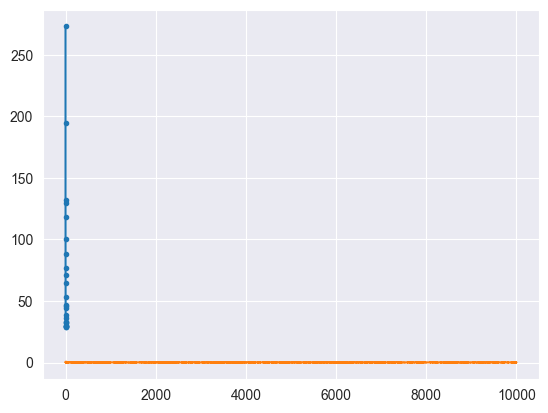

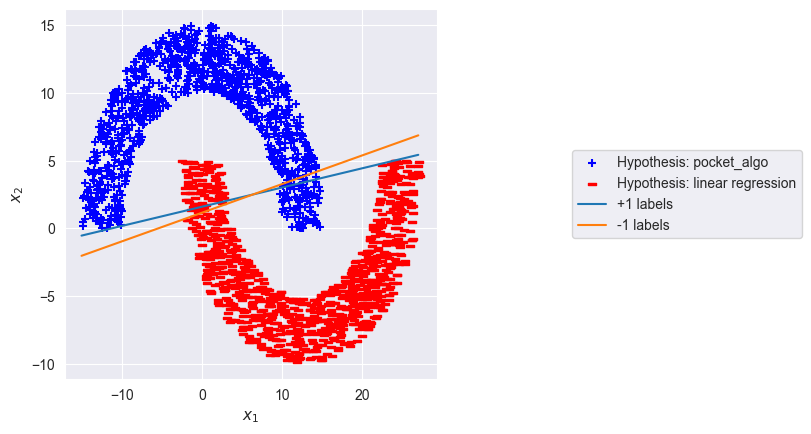

In [6]:
#### Problem 3.3 (b)-(e)
N = 2000
max_v = 10000
rad, thk = 10, 5
eta = 1
use_adaline=False
maxit = 10000
dim = 2
sep = -5
randomized, print_out = True, True

radii, radians = data.generate_random_ring(N, rad, rad + thk, max_v)
xs, ys, signs = data.move_bottom_ring_and_assign(radii, radians, rad + thk / 2.0, -sep)
df = pd.DataFrame({'x1':xs.flatten(), 'x2':ys.flatten(), 'y':signs.flatten()})
df['x0'] = 1
df = df[['x0','x1','x2','y']]

w_pocket, w_ts, what_ts, test_w_ts, test_what_ts, _ = lm.pocket_algo(df.values, dim,
                                                           maxit,eta, randomized,
                                                           print_out, None)

plt.plot(w_ts)

w_lin = lm.linear_regression(df[['x0','x1','x2']].values, df['y'].values)
xs = np.arange(-(rad+thk), (rad+thk)+rad + thk/2)
plot_data_hypothesis(df, xs, [w_pocket, w_lin], ['pocket_algo', 'linear regression'])

In [7]:
#### Problem 3.3 (e)
import time


def polynomial_transformation_2v(df):
    df['x1x2'] = df['x1']*df['x2']
    df['x1_sq'] = df['x1']*df['x1']
    df['x2_sq'] = df['x2']*df['x2']
    df['x2x1_sq'] = df['x2']*df['x1_sq']
    df['x1x2_sq'] = df['x1']*df['x2_sq']
    df['x1_cu'] = df['x1_sq']*df['x1']
    df['x2_cu'] = df['x2_sq']*df['x2']
    df = df[['x0','x1','x2',
             'x1x2', 'x1_sq', 'x2_sq',
             'x1x2_sq', 'x2x1_sq', 'x1_cu', 'x2_cu',
             'y']]
    return df

df_poly = polynomial_transformation_2v(df)
dim_poly = 9
start = time.time()
w_pocket, w_ts, what_ts, test_w_ts, test_what_ts, _ = lm.pocket_algo(df_poly.values, dim_poly,
                                                                  maxit,eta, randomized,
                                                                  print_out, None)
end = time.time()
print("Pocket algorithm time: ", end-start)

plt.plot(w_ts)
start = time.time()
w_lin = lm.linear_regression(df_poly[['x0','x1','x2', 'x1x2', 'x1_sq', 'x2_sq',
                                      'x1x2_sq', 'x2x1_sq', 'x1_cu', 'x2_cu']].values,
                             df_poly['y'].values)
end = time.time()
print("Linear Regression time: ", end-start)
xs = np.arange(-(rad+thk), (rad+thk)+rad + thk/2, 0.1)

final Error Rate:  0.0675
final normalized w: [-1.59938129  2.79285662 -0.84871583 10.66811469 39.20157698 -9.96111081
 -0.69821979  3.92595496 -2.92517424  1.        ]
Pocket algorithm time:  14.266032457351685
Linear Regression time:  0.0010044574737548828


In [8]:
def poly3(x2, x1, w):
    return (w[0] + w[1]*x1 + w[2]*x2 + w[3]*x1*x2
            + w[4]*x1**2 + w[5]*x2**2 + w[6]*x1*x2**2
            + w[7]*x2*x1**2 + w[8]*x1**3+w[9]*x2**3
           )

def get_coeffs(w, x1):
    return [w[9],
            w[6]*x1+w[5],
            w[7]*x1**2+w[3]*x1+w[2],
            w[8]*x1**3+w[4]*x1**2+w[1]*x1+w[0]]

def deriv(x2, x1, w):
    return (3*w[9]*x2**2 + w[7]*x1**2+2*w[6]*x1*x2+2*w[5]*x2+w[3]*x1+w[2])

from functools import partial
import scipy.optimize
from scipy.optimize import minimize
#p3 = partial(poly3, x1= x, w= w_lin)
#d3 = partial(deriv, x1= x, w= w_lin)
#res = minimize(p3, 0, method='BFGS', jac=d3, tol=1e-12)

def find_poly_roots(xs, w):
    x2s1, x2s2, x2s3, vs = [], [], [], []
    for x in xs:
        coeffs = get_coeffs(w, x)
        roots = np.roots(coeffs)
        r1, r2, r3 = roots
        if np.iscomplex(roots[0]):
            if np.iscomplex(roots[1]):
                r1 = r3
                r2 = r3
            elif np.iscomplex(roots[2]):
                r1 = r2
                r3 = r2
        elif np.iscomplex(roots[1]):
            r2 = r1
            r3 = r1

        x2s1.append(r1)
        x2s2.append(r2)
        x2s3.append(r3)
    return x2s1, x2s2, x2s3

C:\Users\sammi\anaconda3\envs\tensorflow-env\lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\sammi\anaconda3\envs\tensorflow-env\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


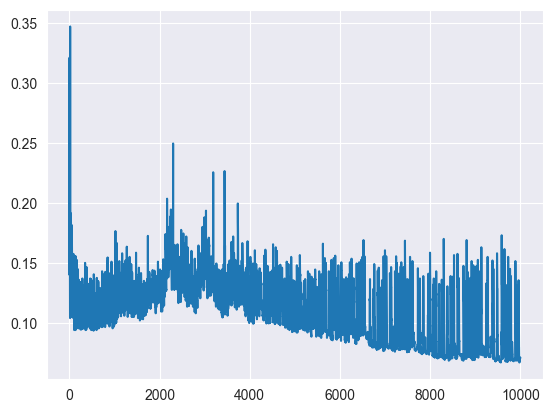

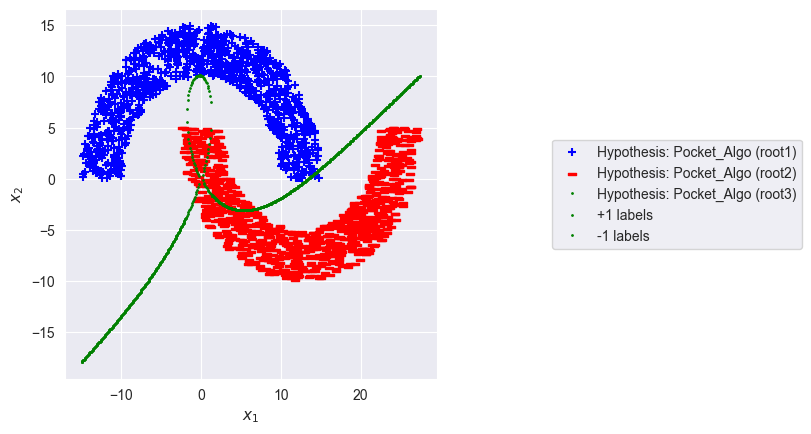

In [9]:
#### Problem 3.3 (e) Polynomial transformation with Pocket algorithm

positives = df_poly.loc[df_poly['y']==1]
negatives = df_poly.loc[df_poly['y']==-1]

figsize = plt.figaspect(1)
f, ax = plt.subplots(1, 1, figsize=figsize)
ps = ax.scatter(positives[['x1']].values, positives[['x2']].values, marker='+', c= 'b', label='+1 labels')
ns = ax.scatter(negatives[['x1']].values, negatives[['x2']].values, marker=r'$-$', c= 'r', label='-1 labels')

labels= ['Hypothesis: Pocket_Algo (root1)',
         'Hypothesis: Pocket_Algo (root2)',
         'Hypothesis: Pocket_Algo (root3)']

x2s1, x2s2, x2s3 = find_poly_roots(xs, w_pocket)
hypothesis = ax.plot(xs, x2s1, marker='.', markersize='2', color='g', linestyle="")
hypothesis = ax.plot(xs, x2s2, marker='.', markersize='2', color='g', linestyle="")
hypothesis = ax.plot(xs, x2s3, marker='.', markersize='2', color='g', linestyle="")

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
#ax.axis('tight')
legend_x = 2.0
legend_y = 0.5
ax.legend(labels + ['+1 labels', '-1 labels'],
          loc='center right', bbox_to_anchor=(legend_x, legend_y))
plt.show()

C:\Users\sammi\anaconda3\envs\tensorflow-env\lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\sammi\anaconda3\envs\tensorflow-env\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


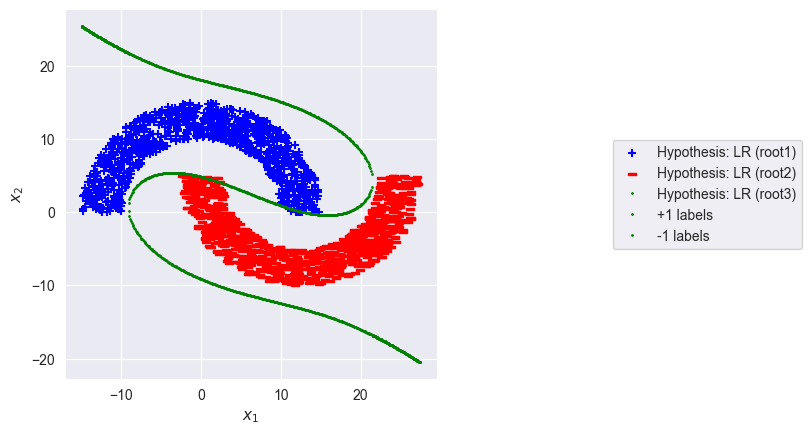

In [10]:
#### Problem 3.3 (e) Polynomial transformation with Linear Regression
positives = df_poly.loc[df_poly['y']==1]
negatives = df_poly.loc[df_poly['y']==-1]

figsize = plt.figaspect(1)
f, ax = plt.subplots(1, 1, figsize=figsize)
ps = ax.scatter(positives[['x1']].values, positives[['x2']].values, marker='+', c= 'b', label='+1 labels')
ns = ax.scatter(negatives[['x1']].values, negatives[['x2']].values, marker=r'$-$', c= 'r', label='-1 labels')

labels= ['Hypothesis: LR (root1)',
         'Hypothesis: LR (root2)',
         'Hypothesis: LR (root3)']

x2s1, x2s2, x2s3 = find_poly_roots(xs, w_lin)
hypothesis = ax.plot(xs, x2s1, marker='.', markersize='2', color='g', linestyle="")
hypothesis = ax.plot(xs, x2s2, marker='.', markersize='2', color='g', linestyle="")
hypothesis = ax.plot(xs, x2s3, marker='.', markersize='2', color='g', linestyle="")

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
#ax.axis('tight')
legend_x = 2.0
legend_y = 0.5
ax.legend(labels + ['+1 labels', '-1 labels'],
          loc='center right', bbox_to_anchor=(legend_x, legend_y))
plt.show()